In [ ]:
import os
from pyspark.sql import SparkSession

host_ip = os.getenv('HOST_IP')
username = os.getenv('USERNAME')

In [ ]:
spark = SparkSession \
    .builder \
    .config("spark.driver.host", host_ip) \
    .config("spark.driver.bindAddress", '0.0.0.0') \
    .config("spark.driver.port", 33139) \
    .config("spark.driver.blockManager.port", 45029) \
    .config("spark.yarn.queue", "development") \
    .appName(f"{host_ip}-{username}") \
    .enableHiveSupport() \
    .getOrCreate()

In [202]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

df = spark.read.json('event-data.json')

In [185]:
# Датасет содержит сведения о сессиях пользователей музыкального сервиса, с указанием текущего времени и даты регистрации пользователя

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [186]:
df.show()

+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|      auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Martin Orford| Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|   John Brown's Body| Logged In|   Sawyer|     M|           74|   Larson|380.21179|

In [203]:
df.createOrReplaceTempView('sessions')

prep_df = spark.sql("""
SELECT
userId as user_id,
from_unixtime(ts / 1000) as event_date
from sessions
where userId != ''
""")

In [ ]:
prep_df.repartition(1).write.csv('prep_df.csv')

In [204]:
prep_df.createOrReplaceTempView('prep_df')

In [190]:
# Расчет DAU и MAU (30 дней назад от даты сессии), MAU календарный

dau_mau_calculated = spark.sql("""
with dau as (
select
    date_trunc('day', event_date) as date,
    count(distinct user_id) as students_dau
from prep_df
group by 1
) , mau as (
select
    date_trunc('month', event_date) as date,
    count(distinct user_id) as students_mau
from prep_df
group by 1 
)

select
    d.date as date,
    d.students_dau,
    count(distinct sess.user_id) as users_30,
    mau.students_mau
from dau as d
left join mau
    on mau.date between date_trunc('month', d.date) and date_trunc('month', d.date) + interval 1 month - interval 1 day
left join prep_df as sess
    on sess.event_date between d.date - interval 30 day and d.date
group by
    d.date,
    d.students_dau,
    students_mau
""")

In [210]:
dau_mau_calculated.show()

+-------------------+------------+--------+------------+
|               date|students_dau|users_30|students_mau|
+-------------------+------------+--------+------------+
|2018-11-27 00:00:00|          80|     390|         383|
|2018-10-11 00:00:00|         131|     370|         430|
|2018-11-19 00:00:00|          91|     393|         383|
|2018-11-16 00:00:00|         105|     396|         383|
|2018-10-10 00:00:00|         120|     360|         430|
|2018-11-10 00:00:00|          81|     401|         383|
|2018-10-13 00:00:00|          78|     388|         430|
|2018-11-30 00:00:00|          96|     381|         383|
|2018-11-21 00:00:00|          86|     395|         383|
|2018-11-12 00:00:00|         101|     393|         383|
|2018-11-13 00:00:00|         104|     395|         383|
|2018-11-23 00:00:00|          89|     397|         383|
|2018-10-15 00:00:00|         111|     392|         430|
|2018-10-30 00:00:00|         117|     422|         430|
|2018-11-01 00:00:00|         1

In [193]:
dau_mau_calculated.repartition(1).write.csv('dau_mau_calculated.csv')

2022-01-27 14:34:12,211 WARN commit.AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [221]:
# Расчет недельного retention

retention_calculated = spark.sql("""
select
  date(date_trunc('day', activity.event_date)) as date, 
  count(distinct activity.user_id) as active_users, 
  count(distinct future_activity.user_id) as retained_users,
  round((count(distinct future_activity.user_id) / 
    count(distinct activity.user_id)) * 100, 2) as retention
from prep_df as activity
left join prep_df as future_activity on
  activity.user_id = future_activity.user_id
  and activity.event_date = future_activity.event_date - interval 1 day
group by 1""")

In [222]:
retention_calculated.show()

+----------+------------+--------------+---------+
|      date|active_users|retained_users|retention|
+----------+------------+--------------+---------+
|2018-11-02|         110|             6|     5.45|
|2018-10-05|         123|             3|     2.44|
|2018-11-01|         106|             3|     2.83|
|2018-10-04|         127|             7|     5.51|
|2018-10-09|         128|             6|     4.69|
|2018-10-07|          53|             1|     1.89|
|2018-10-21|          61|             3|     4.92|
|2018-11-17|          67|             1|     1.49|
|2018-10-15|         111|             5|      4.5|
|2018-10-01|         117|             6|     5.13|
|2018-10-13|          78|             1|     1.28|
|2018-11-26|          96|             7|     7.29|
|2018-11-24|          66|             2|     3.03|
|2018-11-05|         125|             6|      4.8|
|2018-12-01|           4|             0|      0.0|
|2018-10-26|         110|             4|     3.64|
|2018-11-12|         101|      

In [224]:
retention_calculated.repartition(1).write.csv('s3a://uchiru-bi-dwh/dev/retention_calculated.csv')

2022-01-27 15:27:45,594 WARN commit.AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [219]:
import matplotlib.pyplot as plt

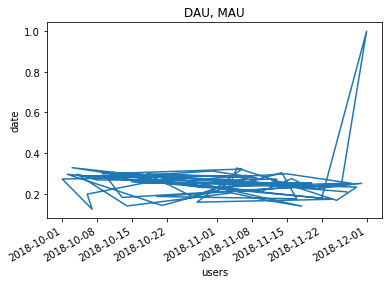

In [196]:
df = dau_mau_calculated.toPandas()
fig, ax = plt.subplots()
df['DAU/MAU'] = df['students_dau'] / df['students_mau']
ax.plot(df['date'],df['DAU/MAU'])
# ax.plot(df['date'], df['students_dau'])
# ax.plot(df['date'], df['students_mau'])
ax.set_title('DAU, MAU')
ax.set_xlabel('users')
ax.set_ylabel('date')
fig.autofmt_xdate()
plt.show()

In [197]:
top_artists = spark.sql("""
Select 
    artist,
    count(artist) as total_mentioned
from sessions
where artist is not null
group by artist
order by total_mentioned desc
""")

In [198]:
top_artists.show()

+--------------------+---------------+
|              artist|total_mentioned|
+--------------------+---------------+
|       Kings Of Leon|           3497|
|            Coldplay|           3439|
|Florence + The Ma...|           2314|
|                Muse|           2194|
|       Dwight Yoakam|           2187|
|      The Black Keys|           2160|
|            BjÃÂ¶rk|           2150|
|       Justin Bieber|           2096|
|        Jack Johnson|           2049|
|           Radiohead|           1694|
|              Eminem|           1686|
|     Alliance Ethnik|           1654|
|         OneRepublic|           1651|
|        Taylor Swift|           1555|
|         The Killers|           1554|
|               Train|           1537|
|         Linkin Park|           1487|
|         Evanescence|           1426|
|          John Mayer|           1350|
|            Harmonia|           1344|
+--------------------+---------------+
only showing top 20 rows



In [199]:
artists = top_artists.select(F.collect_list('artist')).first()[0]
total_mentioned = top_artists.select(F.collect_list('total_mentioned')).first()[0]

top_songs_dict = dict(zip(artists, total_mentioned))

def draw_word_cloud(words):
    cloud_to_draw = WordCloud(width=1280,
                              height=720,
                              max_words=50,
                              background_color="black",
                              relative_scaling=1,
                              normalize_plurals=False,
                              collocations=False)\
                              .generate_from_frequencies(words)
    plt.imshow(cloud_to_draw, interpolation='bilinear')
    plt.axis('off')
    plt.show()

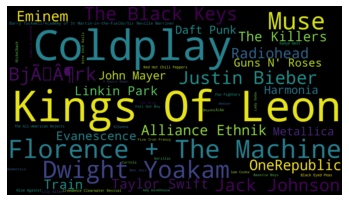

In [200]:
draw_word_cloud(top_songs_dict)